<a href="https://colab.research.google.com/github/aegisen/Project1/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)


Mounted at /content/drive/


In [2]:
# Move to project location
%cd /content/drive/My Drive/Project1

/content/drive/My Drive/Project1


In [3]:
pip install nltk

In [4]:
pip install spacy

In [5]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from nltk.tokenize import word_tokenize
import spacy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from tqdm.autonotebook import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


<ipython-input-5-e8e63de42027>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Creating dataset

In [8]:
train = pd.read_csv("data/train.tsv", sep="\t")
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [9]:
test = pd.read_csv("data/test.tsv", sep="\t")
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [10]:
# Only keep entire reviews
train_reviews = train.drop_duplicates(subset=["SentenceId"], keep = "first")
train_reviews = train_reviews.drop("PhraseId", axis = 1)
train_reviews = train_reviews.reset_index()
train_reviews

,index,SentenceId,Phrase,Sentiment
0,0,1,A series of escapades demonstrating the adage ...,1
1,63,2,"This quiet , introspective and entertaining in...",4
2,81,3,"Even fans of Ismail Merchant 's work , I suspe...",1
3,116,4,A positively thrilling combination of ethnogra...,3
4,156,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
8524,155984,8540,... either you 're willing to go with this cla...,2
8525,155997,8541,"Despite these annoyances , the capable Claybur...",2
8526,156021,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
8527,156031,8543,The movie 's downfall is to substitute plot fo...,1


In [11]:
# Same for test; only keep entire reviews
test_reviews = test.drop_duplicates(subset=["SentenceId"], keep = "first")
test_reviews = test_reviews.drop("PhraseId", axis = 1)
test_reviews = test_reviews.reset_index()
test_reviews

,index,SentenceId,Phrase
0,0,8545,An intermittently pleasing but mostly routine ...
1,15,8546,Kidman is really the only thing that 's worth ...
2,93,8547,Once you get into its rhythm ... the movie bec...
3,117,8548,I kept wishing I was watching a documentary ab...
4,158,8549,"Kinnear does n't aim for our sympathy , but ra..."
...,...,...,...
3305,66220,11851,Not sweet enough to liven up its predictable s...
3306,66239,11852,"Nasty , ugly , pointless and depressing , even..."
3307,66253,11853,"With tightly organized efficiency , numerous f..."
3308,66280,11854,They should have called it Gutterball .


# Cleaning the dataset; Preprocessing

In [12]:
# Function to remove punctuation and make lowercase

def clean(input_df):
  input_df["review"] = input_df["Phrase"].map(lambda x: re.sub(r'[^\w\s]',' ',x)) #you're -> you re... ok?
  input_df["review"] = input_df["review"].apply(lambda x: x.lower())

  return input_df

In [13]:
# Function to add additional rating column (0, 1 = negative; 2 = neutral; 3, 4 = positive)

def add_rating(rating):
  if rating == 0 or rating == 1:
    return "negative"
  elif rating == 3 or rating == 4:
    return "positive"
  else:
    return "neutral"

In [14]:
# Clean review text and add additional label

train_reviews = clean(train_reviews)
train_reviews["rating"] = train_reviews["Sentiment"].apply(add_rating)
train_reviews

,index,SentenceId,Phrase,Sentiment,review,rating
0,0,1,A series of escapades demonstrating the adage ...,1,a series of escapades demonstrating the adage ...,negative
1,63,2,"This quiet , introspective and entertaining in...",4,this quiet introspective and entertaining in...,positive
2,81,3,"Even fans of Ismail Merchant 's work , I suspe...",1,even fans of ismail merchant s work i suspe...,negative
3,116,4,A positively thrilling combination of ethnogra...,3,a positively thrilling combination of ethnogra...,positive
4,156,5,Aggressive self-glorification and a manipulati...,1,aggressive self glorification and a manipulati...,negative
...,...,...,...,...,...,...
8524,155984,8540,... either you 're willing to go with this cla...,2,either you re willing to go with this cla...,neutral
8525,155997,8541,"Despite these annoyances , the capable Claybur...",2,despite these annoyances the capable claybur...,neutral
8526,156021,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1,lrb tries rrb to parody a genre that s al...,negative
8527,156031,8543,The movie 's downfall is to substitute plot fo...,1,the movie s downfall is to substitute plot fo...,negative


In [15]:
# Repeat for test dataset

test_reviews = clean(test_reviews)
#test_reviews["rating"] = test_reviews["Sentiment"].apply(add_rating)
test_reviews

,index,SentenceId,Phrase,review
0,0,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
1,15,8546,Kidman is really the only thing that 's worth ...,kidman is really the only thing that s worth ...
2,93,8547,Once you get into its rhythm ... the movie bec...,once you get into its rhythm the movie bec...
3,117,8548,I kept wishing I was watching a documentary ab...,i kept wishing i was watching a documentary ab...
4,158,8549,"Kinnear does n't aim for our sympathy , but ra...",kinnear does n t aim for our sympathy but ra...
...,...,...,...,...
3305,66220,11851,Not sweet enough to liven up its predictable s...,not sweet enough to liven up its predictable s...
3306,66239,11852,"Nasty , ugly , pointless and depressing , even...",nasty ugly pointless and depressing even...
3307,66253,11853,"With tightly organized efficiency , numerous f...",with tightly organized efficiency numerous f...
3308,66280,11854,They should have called it Gutterball .,they should have called it gutterball


In [16]:
# remove stopwords and keep only "meaningful" words/stems
def process(text):
    # instantiate stemmer class
    stemmer = PorterStemmer()

    # create stopwords list
    stopwords_english = stopwords.words('english')
    words = word_tokenize(text) #tokenize
    text_clean = []
    for word in words:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)
            text_clean.append(stem_word)

    return text_clean

In [17]:
# create new column containing column of significant word tokens
train_reviews["tokens"] = train_reviews["review"].apply(process)
train_reviews

,index,SentenceId,Phrase,Sentiment,review,rating,tokens
0,0,1,A series of escapades demonstrating the adage ...,1,a series of escapades demonstrating the adage ...,negative,"[seri, escapad, demonstr, adag, good, goos, al..."
1,63,2,"This quiet , introspective and entertaining in...",4,this quiet introspective and entertaining in...,positive,"[quiet, introspect, entertain, independ, worth..."
2,81,3,"Even fans of Ismail Merchant 's work , I suspe...",1,even fans of ismail merchant s work i suspe...,negative,"[even, fan, ismail, merchant, work, suspect, w..."
3,116,4,A positively thrilling combination of ethnogra...,3,a positively thrilling combination of ethnogra...,positive,"[posit, thrill, combin, ethnographi, intrigu, ..."
4,156,5,Aggressive self-glorification and a manipulati...,1,aggressive self glorification and a manipulati...,negative,"[aggress, self, glorif, manipul, whitewash]"
...,...,...,...,...,...,...,...
8524,155984,8540,... either you 're willing to go with this cla...,2,either you re willing to go with this cla...,neutral,"[either, will, go, claustrophob, concept]"
8525,155997,8541,"Despite these annoyances , the capable Claybur...",2,despite these annoyances the capable claybur...,neutral,"[despit, annoy, capabl, clayburgh, tambor, rea..."
8526,156021,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1,lrb tries rrb to parody a genre that s al...,negative,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u..."
8527,156031,8543,The movie 's downfall is to substitute plot fo...,1,the movie s downfall is to substitute plot fo...,negative,"[movi, downfal, substitut, plot, person]"


In [18]:
# subset to get relevant columnns
train_set = train_reviews[["SentenceId", "review", "tokens", "Sentiment", "rating"]]
train_set

,SentenceId,review,tokens,Sentiment,rating
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative
...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative


In [19]:
NLP = spacy.load('en_core_web_sm')

def tokenize(text: str) -> str:
    """Preprocess by tokenizing text and remove stopwords"""
    # stopwords
    stop_words = set(stopwords.words('english'))

    # tokenize the text with spacy
    doc = NLP(text)

    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    return " ".join(tokens)

In [20]:
train_set["vector"] = train_set["review"].apply(tokenize)
train_set

<ipython-input-20-751b039b970d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["vector"] = train_set["review"].apply(tokenize)


,SentenceId,review,tokens,Sentiment,rating,vector
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...
...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality


In [21]:
train_set["tokens_string"] = train_set["tokens"].apply(" ".join)
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [22]:
train_set["tokens"].values

array([list(['seri', 'escapad', 'demonstr', 'adag', 'good', 'goos', 'also', 'good', 'gander', 'occasion', 'amus', 'none', 'amount', 'much', 'stori']),
       list(['quiet', 'introspect', 'entertain', 'independ', 'worth', 'seek']),
       list(['even', 'fan', 'ismail', 'merchant', 'work', 'suspect', 'would', 'hard', 'time', 'sit', 'one']),
       ...,
       list(['lrb', 'tri', 'rrb', 'parodi', 'genr', 'alreadi', 'joke', 'unit', 'state']),
       list(['movi', 'downfal', 'substitut', 'plot', 'person']),
       list(['film', 'darkli', 'atmospher', 'herrmann', 'quietli', 'suggest', 'sad', 'obsess', 'beneath', 'hearst', 'forc', 'avuncular', 'chortl'])],
      dtype=object)

In [23]:
# get x and y; vectorized version of text and corresponding sentiment values

vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# choose between stemmed or not

# x = vectorizer.fit_transform(train_set["vector"]).toarray()
# x = tfidf_vectorizer.fit_transform(train_set["vector"]).toarray()
x = tfidf_vectorizer.fit_transform(train_set["tokens_string"]).toarray()

y = train_set['Sentiment'].values

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
y

array([1, 4, 1, ..., 1, 1, 2])

# Prelimary EDA

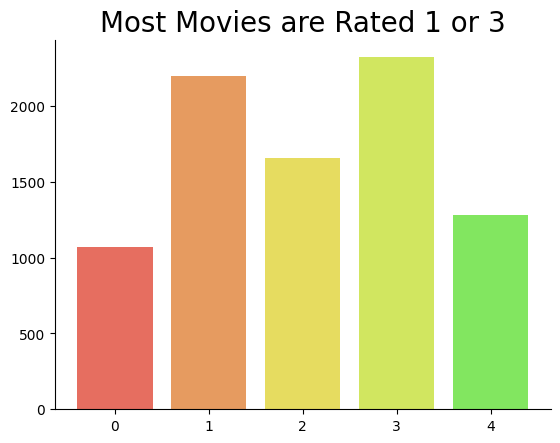

In [26]:
# How common are each rating?

labels, counts = np.unique(train_reviews["Sentiment"], return_counts=True)
ax = plt.subplot(111)
ax.bar(labels, counts, align = "center", color = ["#E66E60", "#E69B60", "#E6DC60", "#D1E660", "#82E660"])
ax.spines[["right", "top"]].set_visible(False)

plt.title("Most Movies are Rated 1 or 3", size = 20)
plt.show()

# We fucking around now

# **Naive Bayes**

In [27]:
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [28]:
# get training and validation sets

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.6062844413178567


<Axes: >

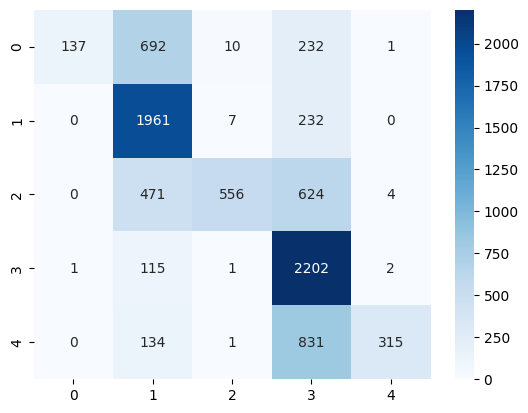

In [29]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB() # default model
naive_bayes.fit(x, y) # fit model on data

y_pred = naive_bayes.predict(x) # predict values

print("Accuracy: ", accuracy_score(y, y_pred)) # get accuracy

cfm = confusion_matrix(y, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## Model not very good, try GridSearch to find better params!

In [30]:
# use tts to just get a subset of the data for faster training purposes

x_grid, _x_gridT, y_grid, _y_gridt = train_test_split(x, y, random_state = 340, test_size = 0.80, shuffle = True)

In [31]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

params = dict()

params = {"fit_prior": (True, False), "alpha": (np.linspace(0.0001, 10, 100))}

In [32]:
# GridSearch
from sklearn.model_selection import GridSearchCV
nb = MultinomialNB()
nb_gridsearch = GridSearchCV(nb, params, cv=10, scoring='accuracy', n_jobs = -1)

nb_gridsearch.fit(x_grid, y_grid)

print(nb_gridsearch.best_score_)
print(nb_gridsearch.best_params_)

0.3677915376676986
{'alpha': 0.5051454545454546, 'fit_prior': True}


In [33]:
alpha = nb_gridsearch.best_params_.get("alpha")
alpha

0.5051454545454546

## Trying another model with better parameters

Accuracy:  0.38569753810082064


<Axes: >

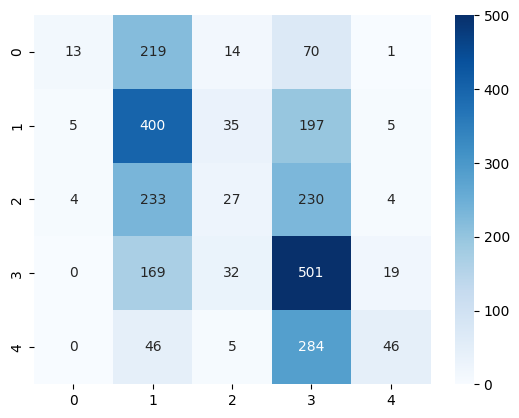

In [34]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = alpha, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

# Logistic Regression

## Testing a model

In [35]:
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [36]:
# try sklearn's Logistic Regression
lr = LogisticRegression(solver = "lbfgs", max_iter = 5000, n_jobs = -1, C = 180)
lr.fit(x, y)
y_pred = lr.predict(x)

accuracy_score(y, y_pred)

0.9964825888146325

<Axes: >

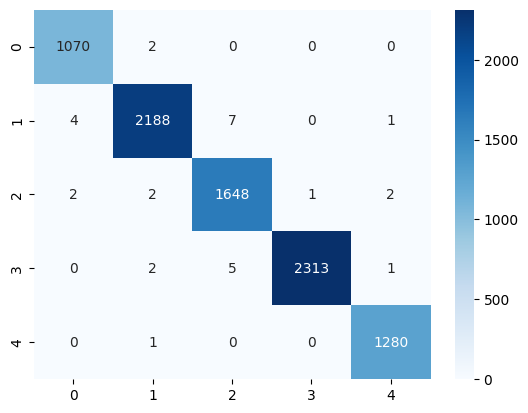

In [37]:
cfm = confusion_matrix(y, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## Try GridSearch to find best params

In [45]:
# use tts to just get a subset of the data for faster training purposes

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 340, test_size = 0.9, shuffle = True)

In [40]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

params = dict()
params["solver"] = ["lbfgs"]
params["penalty"] = ["l2"]
params["C"] = np.logspace(-3,3,50)

In [41]:
# RandomizedSearch

lr = LogisticRegression()
search = RandomizedSearchCV(lr, params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=340)

result = search.fit(x[:500], y[:500])
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.29
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 2.023589647725158}


In [123]:
params = dict()
params["C"] = np.linspace(0.01, 100,50)
#params["max_iter"] = [500, 750, 1000]

In [124]:
# GridSearch
lr = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 500)
lr_gridsearch = GridSearchCV(lr, params, cv=10, scoring='accuracy', n_jobs = -1)

lr_gridsearch.fit(x_train, y_train)

print(lr_gridsearch.best_score_)
print(lr_gridsearch.best_params_)

KeyboardInterrupt: ignored

## Now use these results to build a better model!

In [49]:
len(x)

8529

Accuracy:  0.9964825888146325


<Axes: >

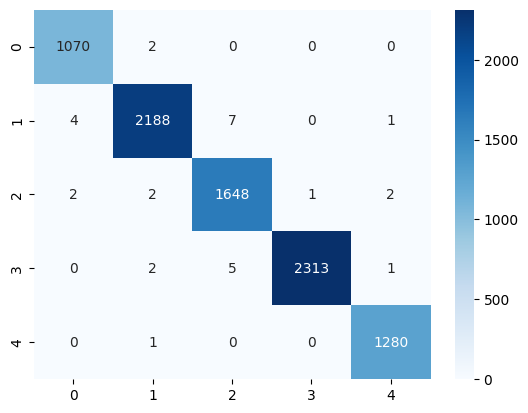

In [50]:
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 5000, n_jobs = -1, C = 187.3817422860383)
lr.fit(x, y)
y_pred = lr.predict(x)
# try normalizer
print("Accuracy: ", accuracy_score(y, y_pred))
cfm = confusion_matrix(y, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## Looks good, but is it overfit?

In [51]:
# get training and validation sets

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.3516998827667057


<Axes: >

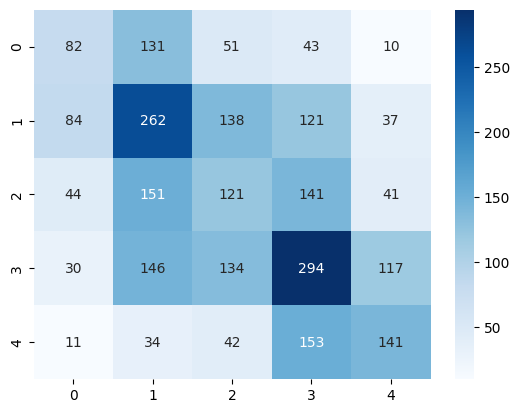

In [52]:
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 8000, n_jobs = -1, C = 187.3817422860383)
lr.fit(x_train, y_train) # train on training data

y_pred = lr.predict(x_test) # predict on test data

print("Accuracy: ", accuracy_score(y_test, y_pred)) # test accuracy on test data
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

# How can we improve the accuracy?
Seems to be overfit...



## Try GloVe Embedding

In [25]:
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [26]:
from GloveEmbed import _get_embedding

glove_file = "glove.6B.300d.txt"

In [27]:
glove_embeds = dict()
f = open(glove_file, "r", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeds[word] = coefs
f.close()


In [28]:
glove_embeds["quiet"]

array([-0.099121 , -0.20046  ,  0.079926 ,  0.13522  ,  0.24477  ,
        0.013652 ,  0.098876 , -0.18809  ,  0.36428  , -1.3044   ,
       -0.34014  , -0.26648  , -0.41871  ,  0.031317 , -0.12765  ,
       -0.023635 , -0.056263 ,  0.085594 ,  0.19659  ,  0.1522   ,
        0.22068  ,  0.46789  ,  0.16712  ,  0.048534 , -0.20515  ,
       -0.15218  ,  0.15951  , -0.22816  ,  0.22275  ,  0.19335  ,
       -0.14156  , -0.18811  , -0.44754  ,  0.13137  , -0.6174   ,
        0.60926  , -0.055783 ,  0.0361   , -0.54026  , -0.20506  ,
        0.39446  ,  0.39475  , -0.10151  ,  0.12025  ,  0.40048  ,
        0.25731  ,  0.38521  ,  0.088834 ,  0.34606  ,  0.69808  ,
        0.2514   ,  0.12245  , -0.012309 ,  0.14109  ,  0.20175  ,
        0.093592 , -0.029057 , -0.29363  ,  0.41025  , -0.13434  ,
        0.4032   , -0.14092  ,  0.56544  ,  0.075149 , -0.19137  ,
       -0.10247  ,  0.49391  , -0.11681  ,  0.53553  , -0.011707 ,
       -0.51068  , -0.16875  ,  0.19958  ,  0.25707  ,  0.0081

In [29]:
strings = train_set["vector"]
x_glove = []
embed_dim = 300

for item in strings:
  sentence = []

  for word in item.split(" "):
    if word in glove_embeds:
      temp = glove_embeds[word]
    else:
      # if word not in glove embed, make it 0
      temp = np.zeros(embed_dim)
    sentence.append(temp)
  sentence = np.mean(sentence, axis = 0)
  x_glove.append(sentence)

In [30]:
x_glove[:5]

[array([ 1.40938638e-02,  1.25584215e-01,  3.23957987e-02, -5.30088656e-02,
         3.67498659e-02,  1.97474882e-01, -7.39608798e-03,  4.97425310e-02,
         1.93200689e-02, -9.91634607e-01,  1.37639910e-01, -3.15699987e-02,
         4.32680734e-03,  1.35542437e-01, -1.59921441e-02,  7.43457302e-02,
        -2.10013196e-01,  4.36169319e-02,  1.33195464e-02, -5.81332110e-02,
        -4.62678187e-02,  2.16967329e-01,  2.41036154e-02,  4.89515252e-02,
        -7.12749287e-02,  6.44953502e-03, -9.99478716e-03, -6.16714098e-02,
        -5.09897582e-02,  1.10025004e-01, -1.81747340e-02,  2.59151161e-02,
        -1.36851400e-01, -1.10885397e-01, -5.34493446e-01,  1.23455986e-01,
        -1.66859716e-01,  1.70999691e-01,  1.58596471e-01, -1.03555515e-01,
         4.25393321e-02, -1.66960403e-01, -8.39767903e-02, -5.63414656e-02,
        -3.58399153e-02,  2.49761537e-01,  1.24398790e-01,  5.47238588e-02,
        -1.09350123e-01,  1.16291724e-01,  1.44092470e-01, -5.19843102e-02,
         1.7

In [31]:
# get training and validation sets

glove_train, glove_test, y_train, y_test = train_test_split(x_glove, y, random_state = 340, test_size = 0.3, shuffle = True)

## Trying with Bayes

In [33]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.5051454545454546, fit_prior = True) # better params
naive_bayes.fit(glove_train, y_train) # fit model on data

y_pred = naive_bayes.predict(glove_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

ValueError: ignored

**input x (glove embedding) has negative values, so we can't use Naive Bayes with it...**

## Trying Logistic Regression

Accuracy:  0.38139898397811645


<Axes: >

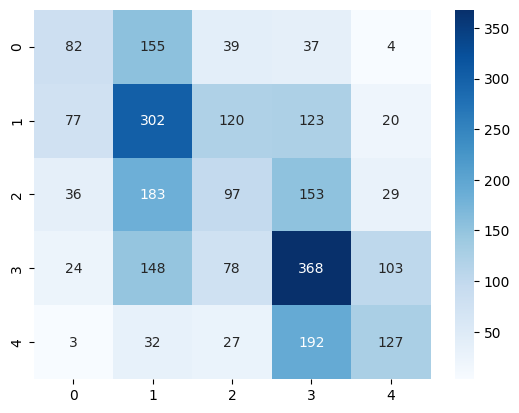

In [34]:
# use best params
lr = LogisticRegression(solver = "sag", max_iter = 5000, n_jobs = -1, C = 187.3817422860383)
lr.fit(glove_train, y_train)
y_pred = lr.predict(glove_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

Very slight accuracy increase... try GridSearch again?

##  GridSearch LR Part 2

In [35]:
# use tts to just get a subset of the data for faster training purposes

glove_grid, _glove_gridT, y_grid, _y_gridt = train_test_split(x_glove, y, random_state = 340, test_size = 0.90, shuffle = True)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

params = dict()
params["solver"] = ["lbfgs", "sag"]
params["C"] = np.logspace(-3,3,30)

In [ ]:
# GridSearch

lr = LogisticRegression(multi_class = "multinomial", max_iter = 5000)
lr_gridsearch = GridSearchCV(lr, params, cv=10, scoring='accuracy', n_jobs = -1)

lr_gridsearch.fit(glove_grid, y_grid)

print(lr_gridsearch.best_score_)
print(lr_gridsearch.best_params_)

Looks like lbfgs will be better... narrowing results

In [ ]:
# GridSearch
params = dict()
params["solver"] = ["lbfgs"]
params["C"] = np.linspace(0.0001, 200, 100)

lr = LogisticRegression(multi_class = "multinomial", max_iter = 5000)
lr_gridsearch = GridSearchCV(lr, params, cv=10, scoring='accuracy', n_jobs = -1)

lr_gridsearch.fit(glove_grid, y_grid)

print(lr_gridsearch.best_score_)
print(lr_gridsearch.best_params_)

## Try GridSearch Params for LR

Accuracy:  0.4075810863618601


<Axes: >

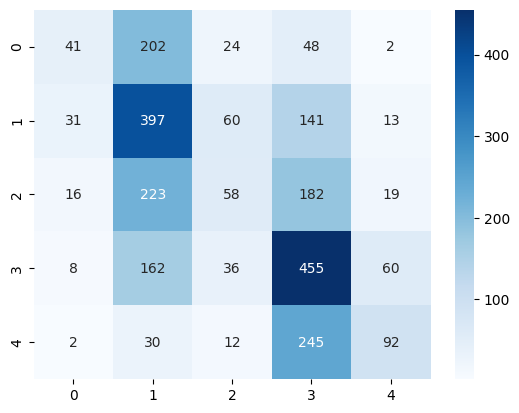

In [39]:
#c = 2.02030101010101
c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = c)
lr.fit(glove_train, y_train)
y_pred = lr.predict(glove_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

There is a slight increase in accuracy, but still below 50%...

# What if we predicted based on positive/negative/neutral labels?

## Trying GloVe/Pos-Neg_Neutral

In [40]:
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [41]:
def get_rating(rating):
  if rating == "negative":
    return 0
  elif rating == "positive":
    return 2
  else:
    return 1

In [42]:
# get numerical representation of pos/neut/neg

y_rating = train_set["rating"].apply(get_rating).values
y_rating

array([0, 2, 0, ..., 0, 0, 1])

In [114]:
# get test/train sets

glove_grid, _glove_gridT, y_grid, _y_gridt = train_test_split(x_glove, y, random_state = 340, test_size = 0.90, shuffle = True)

In [112]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

params = dict()
params["solver"] = ["lbfgs", "sag"]
params["C"] = np.logspace(-3,3,30)

In [115]:
# GridSearch
params = dict()
params["solver"] = ["lbfgs"]
params["C"] = np.linspace(0.0001, 200, 100)

lr = LogisticRegression(multi_class = "multinomial", max_iter = 5000)
lr_gridsearch = GridSearchCV(lr, params, cv=10, scoring='accuracy', n_jobs = -1)

lr_gridsearch.fit(glove_grid, y_grid)

print(lr_gridsearch.best_score_)
print(lr_gridsearch.best_params_)

0.3379753761969904
{'C': 2.02030101010101, 'solver': 'lbfgs'}


Accuracy:  0.621727237202032


<Axes: >

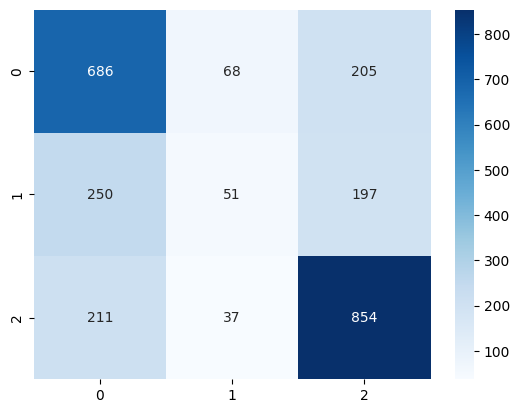

In [50]:
c = 2.02030101010101
#c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = 2)
lr.fit(glove_train, y_train)
y_pred = lr.predict(glove_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

In [51]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.72      0.65       959
           1       0.33      0.10      0.16       498
           2       0.68      0.77      0.72      1102

    accuracy                           0.62      2559
   macro avg       0.53      0.53      0.51      2559
weighted avg       0.58      0.62      0.59      2559



## How about regular TFIDF Vector?

In [52]:
# get x and y; vectorized version of text and corresponding sentiment values

vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# choose between stemmed or not

# x = vectorizer.fit_transform(train_set["vector"]).toarray()
# x = tfidf_vectorizer.fit_transform(train_set["vector"]).toarray()
x = tfidf_vectorizer.fit_transform(train_set["tokens_string"]).toarray()

y = train_set['Sentiment'].values

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x, y_rating, random_state = 340, test_size = 0.3, shuffle = True)

### Logistic Regression

Accuracy:  0.6060961313012896


<Axes: >

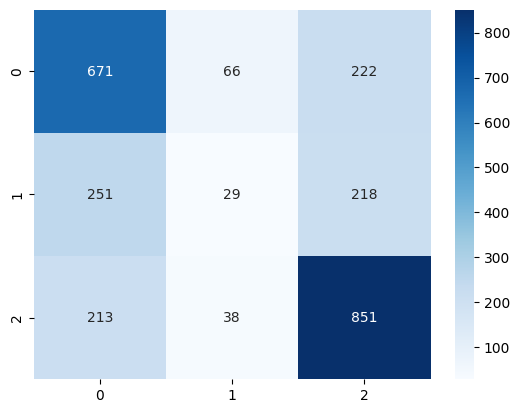

In [126]:
c = 2.02030101010101
#c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = 2)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

It looks like about even accuracy between GloVe embedding and regular TF-IDF...

### Naive Bayes

Accuracy:  0.6287612348573661


<Axes: >

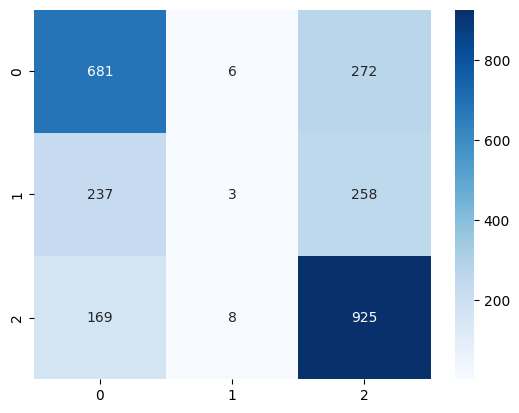

In [127]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.5051454545454546, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

# Overall, model does better with predicting Pos/Neg/Neutral<br>than 0, 1, 2, 3. Both logistic regression and naive Bayes are<br>about the same in performance. With 0/1/2/3 prediction, there<br>is a slight increase when going from TF-IDF to GloVe Embedding,<br>but with Pos/Neg/Neutral prediction, there is not much difference<br>in accuracy between the model or vectorization method.

# What if we used POS Tagging, then tokenized?

## Pre-Processing

In [56]:
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you re willing to go with this cla...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [57]:
# change "re" to "are"
train_set["review"] = train_set["review"].str.replace(" re ", " are ")
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash
...,...,...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person


In [58]:
# tokenize

train_set["POS_tokens"] = train_reviews["review"].apply(word_tokenize)
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string,POS_tokens
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...,"[a, series, of, escapades, demonstrating, the,..."
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek,"[this, quiet, introspective, and, entertaining..."
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...,"[even, fans, of, ismail, merchant, s, work, i,..."
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...,"[a, positively, thrilling, combination, of, et..."
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash,"[aggressive, self, glorification, and, a, mani..."
...,...,...,...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept,"[either, you, re, willing, to, go, with, this,..."
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...,"[despite, these, annoyances, the, capable, cla..."
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state,"[lrb, tries, rrb, to, parody, a, genre, that, ..."
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person,"[the, movie, s, downfall, is, to, substitute, ..."


In [59]:
# remove stopwords

def remove_stopwords(text):
    # create stopwords list
    stopwords_english = stopwords.words('english')
    text_clean = []
    for word in text:
        if (word not in stopwords_english and word not in string.punctuation):
            text_clean.append(word)

    return text_clean


In [60]:
train_set["POS_tokens"] = train_set["POS_tokens"].apply(remove_stopwords)
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string,POS_tokens
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...,"[series, escapades, demonstrating, adage, good..."
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek,"[quiet, introspective, entertaining, independe..."
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...,"[even, fans, ismail, merchant, work, suspect, ..."
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...,"[positively, thrilling, combination, ethnograp..."
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash,"[aggressive, self, glorification, manipulative..."
...,...,...,...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept,"[either, willing, go, claustrophobic, concept]"
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...,"[despite, annoyances, capable, clayburgh, tamb..."
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state,"[lrb, tries, rrb, parody, genre, already, joke..."
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person,"[movie, downfall, substitute, plot, personality]"


In [61]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [62]:
# apply POS tagging

train_set["POS_tokens"] = train_set["POS_tokens"].apply(nltk.pos_tag)
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string,POS_tokens
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...,"[(series, NN), (escapades, VBZ), (demonstratin..."
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek,"[(quiet, JJ), (introspective, JJ), (entertaini..."
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...,"[(even, RB), (fans, NNS), (ismail, VBP), (merc..."
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...,"[(positively, RB), (thrilling, VBG), (combinat..."
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash,"[(aggressive, JJ), (self, NN), (glorification,..."
...,...,...,...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept,"[(either, DT), (willing, JJ), (go, VBP), (clau..."
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...,"[(despite, IN), (annoyances, NNS), (capable, J..."
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state,"[(lrb, JJ), (tries, NNS), (rrb, VBP), (parody,..."
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person,"[(movie, NN), (downfall, NN), (substitute, NN)..."


In [73]:
# POS tagging
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")


pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def change_tag(text):
    newlist = []
    for word, tag in text:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

train_set["POS_tokens"] = train_set["POS_tokens"].apply(change_tag)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [74]:
train_set

,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string,POS_tokens
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...,"[(series, n), (escapades, v), (demonstrating, ..."
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek,"[(quiet, a), (introspective, a), (entertaining..."
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...,"[(even, r), (fans, n), (ismail, v), (merchant,..."
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...,"[(positively, r), (thrilling, v), (combination..."
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash,"[(aggressive, a), (self, n), (glorification, n..."
...,...,...,...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept,"[(either, None), (willing, a), (go, v), (claus..."
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...,"[(despite, None), (annoyances, n), (capable, a..."
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state,"[(lrb, a), (tries, n), (rrb, v), (parody, n), ..."
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person,"[(movie, n), (downfall, n), (substitute, n), (..."


In [75]:
# lemmatization

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_tokens):
    lemma_rew = " "
    for word, pos in pos_tokens:
      if not pos:
          lemma = word
          lemma_rew = lemma_rew + " " + lemma
      else:
          lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
          lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

train_set["lemma"] = train_set["POS_tokens"].apply(lemmatize)
train_set

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,SentenceId,review,tokens,Sentiment,rating,vector,tokens_string,POS_tokens,lemma
0,1,a series of escapades demonstrating the adage ...,"[seri, escapad, demonstr, adag, good, goos, al...",1,negative,series escapade demonstrate adage good goose a...,seri escapad demonstr adag good goos also good...,"[(series, n), (escapades, v), (demonstrating, ...",series escapades demonstrating adage good go...
1,2,this quiet introspective and entertaining in...,"[quiet, introspect, entertain, independ, worth...",4,positive,quiet introspective entertain independent wort...,quiet introspect entertain independ worth seek,"[(quiet, a), (introspective, a), (entertaining...",quiet introspective entertaining independent...
2,3,even fans of ismail merchant s work i suspe...,"[even, fan, ismail, merchant, work, suspect, w...",1,negative,even fan ismail merchant work i suspect would ...,even fan ismail merchant work suspect would ha...,"[(even, r), (fans, n), (ismail, v), (merchant,...",even fan ismail merchant work suspect would ...
3,4,a positively thrilling combination of ethnogra...,"[posit, thrill, combin, ethnographi, intrigu, ...",3,positive,positively thrilling combination ethnography i...,posit thrill combin ethnographi intrigu betray...,"[(positively, r), (thrilling, v), (combination...",positively thrill combination ethnography in...
4,5,aggressive self glorification and a manipulati...,"[aggress, self, glorif, manipul, whitewash]",1,negative,aggressive self glorification manipulative whi...,aggress self glorif manipul whitewash,"[(aggressive, a), (self, n), (glorification, n...",aggressive self glorification manipulative w...
...,...,...,...,...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,"[either, will, go, claustrophob, concept]",2,neutral,either willing go claustrophobic concept,either will go claustrophob concept,"[(either, None), (willing, a), (go, v), (claus...",either willing go claustrophobic concept
8525,8541,despite these annoyances the capable claybur...,"[despit, annoy, capabl, clayburgh, tambor, rea...",2,neutral,despite annoyance capable clayburgh tambor rea...,despit annoy capabl clayburgh tambor realli gr...,"[(despite, None), (annoyances, n), (capable, a...",despite annoyance capable clayburgh tambor r...
8526,8542,lrb tries rrb to parody a genre that s al...,"[lrb, tri, rrb, parodi, genr, alreadi, joke, u...",1,negative,lrb try rrb parody genre already joke united s...,lrb tri rrb parodi genr alreadi joke unit state,"[(lrb, a), (tries, n), (rrb, v), (parody, n), ...",lrb try rrb parody genre already joke united...
8527,8543,the movie s downfall is to substitute plot fo...,"[movi, downfal, substitut, plot, person]",1,negative,movie downfall substitute plot personality,movi downfal substitut plot person,"[(movie, n), (downfall, n), (substitute, n), (...",movie downfall substitute plot personality


In [76]:
# get a subset; too many columns!

POS_train = train_set[["SentenceId", "review", "lemma", "Sentiment", "rating"]]
POS_train

,SentenceId,review,lemma,Sentiment,rating
0,1,a series of escapades demonstrating the adage ...,series escapades demonstrating adage good go...,1,negative
1,2,this quiet introspective and entertaining in...,quiet introspective entertaining independent...,4,positive
2,3,even fans of ismail merchant s work i suspe...,even fan ismail merchant work suspect would ...,1,negative
3,4,a positively thrilling combination of ethnogra...,positively thrill combination ethnography in...,3,positive
4,5,aggressive self glorification and a manipulati...,aggressive self glorification manipulative w...,1,negative
...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,either willing go claustrophobic concept,2,neutral
8525,8541,despite these annoyances the capable claybur...,despite annoyance capable clayburgh tambor r...,2,neutral
8526,8542,lrb tries rrb to parody a genre that s al...,lrb try rrb parody genre already joke united...,1,negative
8527,8543,the movie s downfall is to substitute plot fo...,movie downfall substitute plot personality,1,negative


In [77]:
# now vectorize + get x and y; vectorized version of text and corresponding sentiment values

vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# choose between stemmed or not

# x = vectorizer.fit_transform(train_set["vector"]).toarray()
# x = tfidf_vectorizer.fit_transform(train_set["vector"]).toarray()
x = tfidf_vectorizer.fit_transform(train_set["lemma"]).toarray()

y = train_set['Sentiment'].values

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Model Training: Logistic Regression

### 0/1/2/3 Prediction

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.4075810863618601


<Axes: >

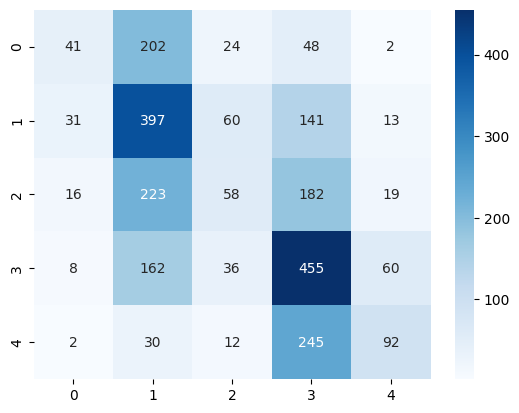

In [79]:
#c = 2.02030101010101
c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = c)
lr.fit(glove_train, y_train)
y_pred = lr.predict(glove_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

### Pos/Neg/Neutral Prediction

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y_rating, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.6240719030871434


<Axes: >

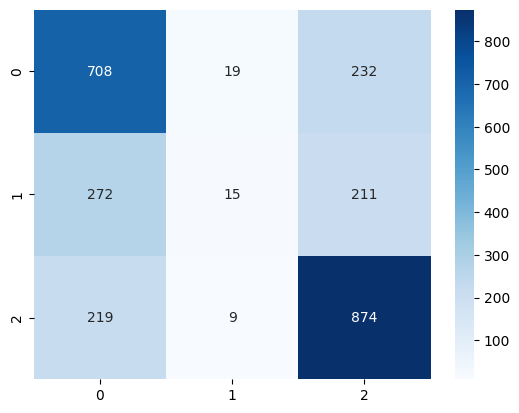

In [81]:
#c = 2.02030101010101
c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = c)
lr.fit(glove_train, y_train)
y_pred = lr.predict(glove_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## Naive Bayes

### 0/1/2/3 Prediction

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.3899960922235248


<Axes: >

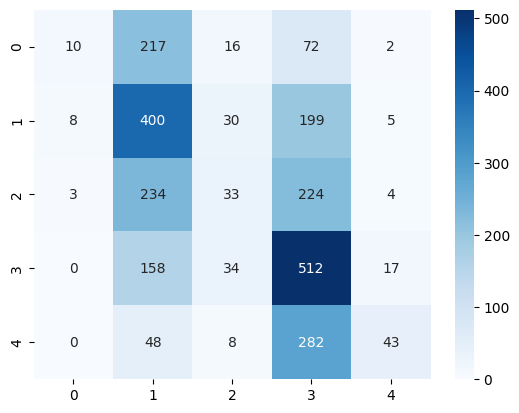

In [83]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.504, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

### Pos/Neg/Neutral Prediction

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, y_rating, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.6287612348573661


<Axes: >

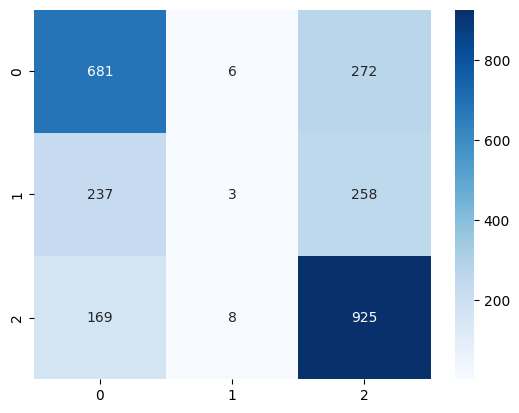

In [85]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.5051454545454546, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## It seems that Naive Bayes/Pos-Neg-Neutral/POS-Tagged Model<br>is the most accurate. Check if Params can get any better...<br>and test GloVe embedding!

# Naive Bayes/Pos-Neg-Neutral/POS-Tagged Model

## GloVe Training: Logistic Regression

In [86]:
POS_train

,SentenceId,review,lemma,Sentiment,rating
0,1,a series of escapades demonstrating the adage ...,series escapades demonstrating adage good go...,1,negative
1,2,this quiet introspective and entertaining in...,quiet introspective entertaining independent...,4,positive
2,3,even fans of ismail merchant s work i suspe...,even fan ismail merchant work suspect would ...,1,negative
3,4,a positively thrilling combination of ethnogra...,positively thrill combination ethnography in...,3,positive
4,5,aggressive self glorification and a manipulati...,aggressive self glorification manipulative w...,1,negative
...,...,...,...,...,...
8524,8540,either you are willing to go with this cl...,either willing go claustrophobic concept,2,neutral
8525,8541,despite these annoyances the capable claybur...,despite annoyance capable clayburgh tambor r...,2,neutral
8526,8542,lrb tries rrb to parody a genre that s al...,lrb try rrb parody genre already joke united...,1,negative
8527,8543,the movie s downfall is to substitute plot fo...,movie downfall substitute plot personality,1,negative


In [87]:
from GloveEmbed import _get_embedding

glove_file = "glove.6B.300d.txt"

In [88]:
glove_embeds = dict()
f = open(glove_file, "r", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeds[word] = coefs
f.close()


In [89]:
strings = train_set["lemma"]
x_glove = []
embed_dim = 300

for item in strings:
  sentence = []

  for word in item.split(" "):
    if word in glove_embeds:
      temp = glove_embeds[word]
    else:
      # if word not in glove embed, make it 0
      temp = np.zeros(embed_dim)
    sentence.append(temp)
  sentence = np.mean(sentence, axis = 0)
  x_glove.append(sentence)

### 0/1/2/3

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x_glove, y, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.42243063696756544


<Axes: >

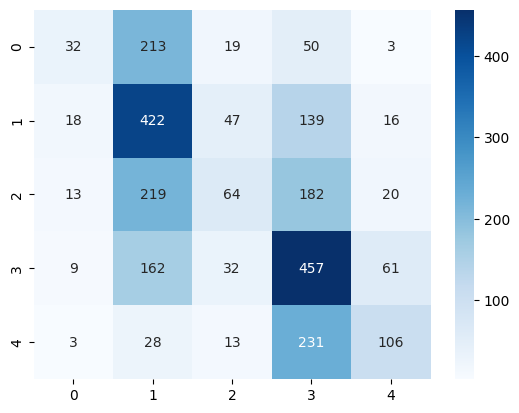

In [91]:
#c = 2.02030101010101
c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = c)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

Best result for 0/1/2/3 so far...

### Pos/Neg/Neutral

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y_rating, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.6060961313012896


<Axes: >

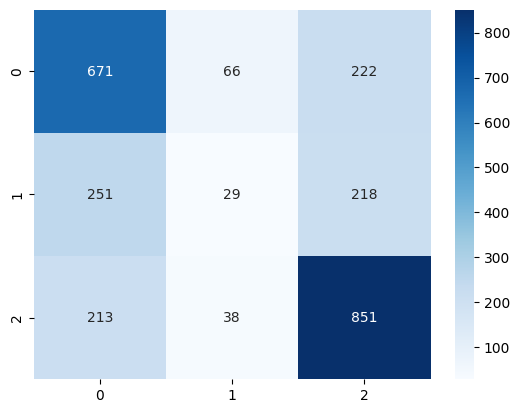

In [93]:
c = 2.02030101010101
#c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = c)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
cfm = confusion_matrix(y_test, y_pred)

## Let's plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

## Back to Naive Bayes...

In [94]:
# just to be safe

vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# choose between stemmed or not

# x = vectorizer.fit_transform(train_set["vector"]).toarray()
# x = tfidf_vectorizer.fit_transform(train_set["vector"]).toarray()
x = tfidf_vectorizer.fit_transform(train_set["lemma"]).toarray()

y = train_set['Sentiment'].values

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### GridSearch for 0/1/2/3

In [95]:
x_grid, _x_test, y_grid, _y_test = train_test_split(x, y, random_state = 340, test_size = 0.7, shuffle = True)

In [96]:
params = dict()

params = {"fit_prior": (True, False), "alpha": (np.linspace(0.0001, 10, 150))}

In [97]:
# GridSearch
from sklearn.model_selection import GridSearchCV
nb = MultinomialNB()
nb_gridsearch = GridSearchCV(nb, params, cv=10, scoring='accuracy', n_jobs = -1)

nb_gridsearch.fit(x_grid, y_grid)

print(nb_gridsearch.best_score_)
print(nb_gridsearch.best_params_)

0.3835033700980392
{'alpha': 0.26855369127516776, 'fit_prior': True}


### 0/1/2/3 with Best Params

In [98]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.3841344275107464


<Axes: >

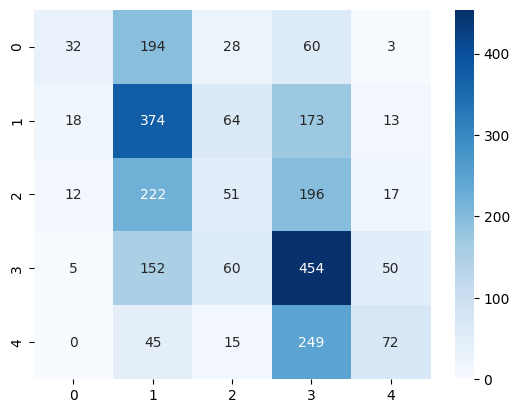

In [99]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.26855369127516776, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

### Grid Search for Pos/Neg/Neutral

In [103]:
x_grid, _x_test, y_grid, _y_test = train_test_split(x, y_rating, random_state = 340, test_size = 0.8, shuffle = True)

In [104]:
params = dict()

params = {"fit_prior": (True, False), "alpha": (np.linspace(0.0001, 10, 150))}

In [105]:
# GridSearch
from sklearn.model_selection import GridSearchCV
nb = MultinomialNB()
nb_gridsearch = GridSearchCV(nb, params, cv=10, scoring='accuracy', n_jobs = -1)

nb_gridsearch.fit(x_grid, y_grid)

print(nb_gridsearch.best_score_)
print(nb_gridsearch.best_params_)

0.5859683522531819
{'alpha': 0.26855369127516776, 'fit_prior': True}


### Pos/Neg/Neutral with Best Params

In [106]:
x_train, x_test, y_train, y_test = train_test_split(x, y_rating, random_state = 340, test_size = 0.3, shuffle = True)

Accuracy:  0.634232121922626


<Axes: >

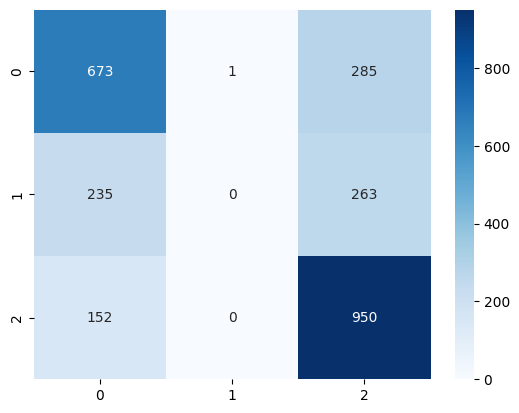

In [129]:
# trying naive bayes model
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.86855369127516776, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

print("Accuracy: ", accuracy_score(y_test, y_pred)) # get accuracy

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')

# The best model for predicting on Pos/Neg/Neutral labels is Naive Bayes<br>with POS tagging, and the best model for 0/1/2/3 prediction is<br>Logistic Regression with POS Tagging and GloVe Embedding.

## Pre-Processing for Test Data

In [131]:
test_reviews

,index,SentenceId,Phrase,review
0,0,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
1,15,8546,Kidman is really the only thing that 's worth ...,kidman is really the only thing that s worth ...
2,93,8547,Once you get into its rhythm ... the movie bec...,once you get into its rhythm the movie bec...
3,117,8548,I kept wishing I was watching a documentary ab...,i kept wishing i was watching a documentary ab...
4,158,8549,"Kinnear does n't aim for our sympathy , but ra...",kinnear does n t aim for our sympathy but ra...
...,...,...,...,...
3305,66220,11851,Not sweet enough to liven up its predictable s...,not sweet enough to liven up its predictable s...
3306,66239,11852,"Nasty , ugly , pointless and depressing , even...",nasty ugly pointless and depressing even...
3307,66253,11853,"With tightly organized efficiency , numerous f...",with tightly organized efficiency numerous f...
3308,66280,11854,They should have called it Gutterball .,they should have called it gutterball


In [132]:
# Clean review text

test_reviews = clean(test_reviews)
test_reviews

,index,SentenceId,Phrase,review
0,0,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
1,15,8546,Kidman is really the only thing that 's worth ...,kidman is really the only thing that s worth ...
2,93,8547,Once you get into its rhythm ... the movie bec...,once you get into its rhythm the movie bec...
3,117,8548,I kept wishing I was watching a documentary ab...,i kept wishing i was watching a documentary ab...
4,158,8549,"Kinnear does n't aim for our sympathy , but ra...",kinnear does n t aim for our sympathy but ra...
...,...,...,...,...
3305,66220,11851,Not sweet enough to liven up its predictable s...,not sweet enough to liven up its predictable s...
3306,66239,11852,"Nasty , ugly , pointless and depressing , even...",nasty ugly pointless and depressing even...
3307,66253,11853,"With tightly organized efficiency , numerous f...",with tightly organized efficiency numerous f...
3308,66280,11854,They should have called it Gutterball .,they should have called it gutterball


In [134]:
# change "re" to "are"

test_reviews["review"] = test_reviews["review"].str.replace(" re ", " are ")
test_reviews

,index,SentenceId,Phrase,review
0,0,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...
1,15,8546,Kidman is really the only thing that 's worth ...,kidman is really the only thing that s worth ...
2,93,8547,Once you get into its rhythm ... the movie bec...,once you get into its rhythm the movie bec...
3,117,8548,I kept wishing I was watching a documentary ab...,i kept wishing i was watching a documentary ab...
4,158,8549,"Kinnear does n't aim for our sympathy , but ra...",kinnear does n t aim for our sympathy but ra...
...,...,...,...,...
3305,66220,11851,Not sweet enough to liven up its predictable s...,not sweet enough to liven up its predictable s...
3306,66239,11852,"Nasty , ugly , pointless and depressing , even...",nasty ugly pointless and depressing even...
3307,66253,11853,"With tightly organized efficiency , numerous f...",with tightly organized efficiency numerous f...
3308,66280,11854,They should have called it Gutterball .,they should have called it gutterball


In [135]:
# tokenize

test_reviews["POS_tokens"] = test_reviews["review"].apply(word_tokenize)
test_reviews

,index,SentenceId,Phrase,review,POS_tokens
0,0,8545,An intermittently pleasing but mostly routine ...,an intermittently pleasing but mostly routine ...,"[an, intermittently, pleasing, but, mostly, ro..."
1,15,8546,Kidman is really the only thing that 's worth ...,kidman is really the only thing that s worth ...,"[kidman, is, really, the, only, thing, that, s..."
2,93,8547,Once you get into its rhythm ... the movie bec...,once you get into its rhythm the movie bec...,"[once, you, get, into, its, rhythm, the, movie..."
3,117,8548,I kept wishing I was watching a documentary ab...,i kept wishing i was watching a documentary ab...,"[i, kept, wishing, i, was, watching, a, docume..."
4,158,8549,"Kinnear does n't aim for our sympathy , but ra...",kinnear does n t aim for our sympathy but ra...,"[kinnear, does, n, t, aim, for, our, sympathy,..."
...,...,...,...,...,...
3305,66220,11851,Not sweet enough to liven up its predictable s...,not sweet enough to liven up its predictable s...,"[not, sweet, enough, to, liven, up, its, predi..."
3306,66239,11852,"Nasty , ugly , pointless and depressing , even...",nasty ugly pointless and depressing even...,"[nasty, ugly, pointless, and, depressing, even..."
3307,66253,11853,"With tightly organized efficiency , numerous f...",with tightly organized efficiency numerous f...,"[with, tightly, organized, efficiency, numerou..."
3308,66280,11854,They should have called it Gutterball .,they should have called it gutterball,"[they, should, have, called, it, gutterball]"


In [136]:
# subset

test_set = test_reviews[["SentenceId", "review", "POS_tokens"]]
test_set

,SentenceId,review,POS_tokens
0,8545,an intermittently pleasing but mostly routine ...,"[an, intermittently, pleasing, but, mostly, ro..."
1,8546,kidman is really the only thing that s worth ...,"[kidman, is, really, the, only, thing, that, s..."
2,8547,once you get into its rhythm the movie bec...,"[once, you, get, into, its, rhythm, the, movie..."
3,8548,i kept wishing i was watching a documentary ab...,"[i, kept, wishing, i, was, watching, a, docume..."
4,8549,kinnear does n t aim for our sympathy but ra...,"[kinnear, does, n, t, aim, for, our, sympathy,..."
...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[not, sweet, enough, to, liven, up, its, predi..."
3306,11852,nasty ugly pointless and depressing even...,"[nasty, ugly, pointless, and, depressing, even..."
3307,11853,with tightly organized efficiency numerous f...,"[with, tightly, organized, efficiency, numerou..."
3308,11854,they should have called it gutterball,"[they, should, have, called, it, gutterball]"


In [137]:
# remove stopwords

def remove_stopwords(text):
    # create stopwords list
    stopwords_english = stopwords.words('english')
    text_clean = []
    for word in text:
        if (word not in stopwords_english and word not in string.punctuation):
            text_clean.append(word)

    return text_clean


In [138]:
test_set["POS_tokens"] = test_set["POS_tokens"].apply(remove_stopwords)
test_set

<ipython-input-138-cafaa3fdcf12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["POS_tokens"] = test_set["POS_tokens"].apply(remove_stopwords)


,SentenceId,review,POS_tokens
0,8545,an intermittently pleasing but mostly routine ...,"[intermittently, pleasing, mostly, routine, ef..."
1,8546,kidman is really the only thing that s worth ...,"[kidman, really, thing, worth, watching, birth..."
2,8547,once you get into its rhythm the movie bec...,"[get, rhythm, movie, becomes, heady, experience]"
3,8548,i kept wishing i was watching a documentary ab...,"[kept, wishing, watching, documentary, wartime..."
4,8549,kinnear does n t aim for our sympathy but ra...,"[kinnear, n, aim, sympathy, rather, delivers, ..."
...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[sweet, enough, liven, predictable, story, lea..."
3306,11852,nasty ugly pointless and depressing even...,"[nasty, ugly, pointless, depressing, even, hat..."
3307,11853,with tightly organized efficiency numerous f...,"[tightly, organized, efficiency, numerous, fla..."
3308,11854,they should have called it gutterball,"[called, gutterball]"


In [139]:
# apply POS tagging

test_set["POS_tokens"] = test_set["POS_tokens"].apply(nltk.pos_tag)
test_set

<ipython-input-139-17fc98f9dd24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["POS_tokens"] = test_set["POS_tokens"].apply(nltk.pos_tag)


,SentenceId,review,POS_tokens
0,8545,an intermittently pleasing but mostly routine ...,"[(intermittently, RB), (pleasing, VBG), (mostl..."
1,8546,kidman is really the only thing that s worth ...,"[(kidman, NNS), (really, RB), (thing, NN), (wo..."
2,8547,once you get into its rhythm the movie bec...,"[(get, VB), (rhythm, JJ), (movie, NN), (become..."
3,8548,i kept wishing i was watching a documentary ab...,"[(kept, VB), (wishing, VBG), (watching, VBG), ..."
4,8549,kinnear does n t aim for our sympathy but ra...,"[(kinnear, JJ), (n, JJ), (aim, NN), (sympathy,..."
...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[(sweet, JJ), (enough, RB), (liven, JJ), (pred..."
3306,11852,nasty ugly pointless and depressing even...,"[(nasty, JJ), (ugly, RB), (pointless, VBP), (d..."
3307,11853,with tightly organized efficiency numerous f...,"[(tightly, RB), (organized, VBN), (efficiency,..."
3308,11854,they should have called it gutterball,"[(called, VBN), (gutterball, NN)]"


In [140]:
# change tagging
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")


pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def change_tag(text):
    newlist = []
    for word, tag in text:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

test_set["POS_tokens"] = test_set["POS_tokens"].apply(change_tag)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
<ipython-input-140-7ba4a1bd609a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["POS_tokens"] = test_set["POS_tokens"].apply(change_tag)


In [141]:
test_set

,SentenceId,review,POS_tokens
0,8545,an intermittently pleasing but mostly routine ...,"[(intermittently, r), (pleasing, v), (mostly, ..."
1,8546,kidman is really the only thing that s worth ...,"[(kidman, n), (really, r), (thing, n), (worth,..."
2,8547,once you get into its rhythm the movie bec...,"[(get, v), (rhythm, a), (movie, n), (becomes, ..."
3,8548,i kept wishing i was watching a documentary ab...,"[(kept, v), (wishing, v), (watching, v), (docu..."
4,8549,kinnear does n t aim for our sympathy but ra...,"[(kinnear, a), (n, a), (aim, n), (sympathy, n)..."
...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[(sweet, a), (enough, r), (liven, a), (predict..."
3306,11852,nasty ugly pointless and depressing even...,"[(nasty, a), (ugly, r), (pointless, v), (depre..."
3307,11853,with tightly organized efficiency numerous f...,"[(tightly, r), (organized, v), (efficiency, n)..."
3308,11854,they should have called it gutterball,"[(called, v), (gutterball, n)]"


In [142]:
# lemmatization

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_tokens):
    lemma_rew = " "
    for word, pos in pos_tokens:
      if not pos:
          lemma = word
          lemma_rew = lemma_rew + " " + lemma
      else:
          lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
          lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

test_set["lemma"] = test_set["POS_tokens"].apply(lemmatize)
test_set

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-142-8a7b02039013>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["lemma"] = test_set["POS_tokens"].apply(lemmatize)


,SentenceId,review,POS_tokens,lemma
0,8545,an intermittently pleasing but mostly routine ...,"[(intermittently, r), (pleasing, v), (mostly, ...",intermittently please mostly routine effort
1,8546,kidman is really the only thing that s worth ...,"[(kidman, n), (really, r), (thing, n), (worth,...",kidman really thing worth watch birthday gir...
2,8547,once you get into its rhythm the movie bec...,"[(get, v), (rhythm, a), (movie, n), (becomes, ...",get rhythm movie become heady experience
3,8548,i kept wishing i was watching a documentary ab...,"[(kept, v), (wishing, v), (watching, v), (docu...",keep wish watch documentary wartime navajos ...
4,8549,kinnear does n t aim for our sympathy but ra...,"[(kinnear, a), (n, a), (aim, n), (sympathy, n)...",kinnear n aim sympathy rather delivers perfo...
...,...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[(sweet, a), (enough, r), (liven, a), (predict...",sweet enough liven predictable story leave e...
3306,11852,nasty ugly pointless and depressing even...,"[(nasty, a), (ugly, r), (pointless, v), (depre...",nasty ugly pointless depress even hate clown
3307,11853,with tightly organized efficiency numerous f...,"[(tightly, r), (organized, v), (efficiency, n)...",tightly organize efficiency numerous flashba...
3308,11854,they should have called it gutterball,"[(called, v), (gutterball, n)]",call gutterball


In [170]:
# just to be safe

vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

x_train = tfidf_vectorizer.fit_transform(train_set["lemma"]).toarray()
x_test = tfidf_vectorizer.transform(test_set["lemma"]).toarray()

y_train_s = train_set['Sentiment'].values
y_train_r = train_set['rating'].values

y_train_s

array([1, 4, 1, ..., 1, 1, 2])

## Use Test Data on Model: Naive Bayes

In [162]:
# test data on NB
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB(alpha = 0.86855369127516776, fit_prior = True) # better params
naive_bayes.fit(x_train, y_train_r) # fit model on data

y_pred = naive_bayes.predict(x_test) # predict values

test_set["rating"] = y_pred
test_set

,SentenceId,review,POS_tokens,lemma,Sentiment,rating
0,8545,an intermittently pleasing but mostly routine ...,"[(intermittently, r), (pleasing, v), (mostly, ...",intermittently please mostly routine effort,positive,3
1,8546,kidman is really the only thing that s worth ...,"[(kidman, n), (really, r), (thing, n), (worth,...",kidman really thing worth watch birthday gir...,positive,3
2,8547,once you get into its rhythm the movie bec...,"[(get, v), (rhythm, a), (movie, n), (becomes, ...",get rhythm movie become heady experience,positive,1
3,8548,i kept wishing i was watching a documentary ab...,"[(kept, v), (wishing, v), (watching, v), (docu...",keep wish watch documentary wartime navajos ...,positive,3
4,8549,kinnear does n t aim for our sympathy but ra...,"[(kinnear, a), (n, a), (aim, n), (sympathy, n)...",kinnear n aim sympathy rather delivers perfo...,positive,3
...,...,...,...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[(sweet, a), (enough, r), (liven, a), (predict...",sweet enough liven predictable story leave e...,negative,3
3306,11852,nasty ugly pointless and depressing even...,"[(nasty, a), (ugly, r), (pointless, v), (depre...",nasty ugly pointless depress even hate clown,negative,1
3307,11853,with tightly organized efficiency numerous f...,"[(tightly, r), (organized, v), (efficiency, n)...",tightly organize efficiency numerous flashba...,positive,3
3308,11854,they should have called it gutterball,"[(called, v), (gutterball, n)]",call gutterball,negative,1


In [163]:
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)

[['negative' '1358']
 ['neutral' '7']
 ['positive' '1945']]


## Use Test Data on Model: Logistic Regression

In [167]:
# test data on LR
c = 0.0727895384398315
# use best params
lr = LogisticRegression(solver = "lbfgs", max_iter = 10000, n_jobs = -1, C = c)
lr.fit(x_train, y_train_s)

y_pred = lr.predict(x_test)

test_set["Sentiment"] = y_pred
test_set

,SentenceId,review,POS_tokens,lemma,Sentiment,rating
0,8545,an intermittently pleasing but mostly routine ...,"[(intermittently, r), (pleasing, v), (mostly, ...",intermittently please mostly routine effort,3,3
1,8546,kidman is really the only thing that s worth ...,"[(kidman, n), (really, r), (thing, n), (worth,...",kidman really thing worth watch birthday gir...,3,3
2,8547,once you get into its rhythm the movie bec...,"[(get, v), (rhythm, a), (movie, n), (becomes, ...",get rhythm movie become heady experience,1,1
3,8548,i kept wishing i was watching a documentary ab...,"[(kept, v), (wishing, v), (watching, v), (docu...",keep wish watch documentary wartime navajos ...,3,3
4,8549,kinnear does n t aim for our sympathy but ra...,"[(kinnear, a), (n, a), (aim, n), (sympathy, n)...",kinnear n aim sympathy rather delivers perfo...,3,3
...,...,...,...,...,...,...
3305,11851,not sweet enough to liven up its predictable s...,"[(sweet, a), (enough, r), (liven, a), (predict...",sweet enough liven predictable story leave e...,3,3
3306,11852,nasty ugly pointless and depressing even...,"[(nasty, a), (ugly, r), (pointless, v), (depre...",nasty ugly pointless depress even hate clown,1,1
3307,11853,with tightly organized efficiency numerous f...,"[(tightly, r), (organized, v), (efficiency, n)...",tightly organize efficiency numerous flashba...,3,3
3308,11854,they should have called it gutterball,"[(called, v), (gutterball, n)]",call gutterball,1,1


In [169]:
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0    3]
 [   1 1206]
 [   3 2095]
 [   4    6]]


# While the Naive Bayes model (predicting on 3 classes) is more prone to predicting edge values (the extremes), the Logistic Regression model tends to stray from the extremes, most often predicting reviews as 1 or 3. Interestingly, the Logistic Regression never predicts something as neutral (2).